In [1]:
import sys
import os
import json
sys.path.append("..")

import torch
from torch.optim.lr_scheduler import LambdaLR, StepLR
import torch.optim as optim
import random 
import numpy as np

from tasks.burgers_1d import Burgers1D
from models.pinns import PINN, SA_PINN, DB_PINN, PirateNetPINN, BasePINN
from models.base_models import ResNet
from models.utils.schedulers import LambdaScheduler
from common.train_functions import *
from common.plotting import *

import seaborn as sns

In [2]:
print("CUDA Version:", torch.version.cuda)
print(torch.backends.cudnn.enabled)  # Should be True
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))

CUDA Version: 12.8
True
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
def save_eval_losses(eval_losses, filename):
    with open(filename, 'w') as f:
        json.dump(eval_losses, f)

def save_u_results(T, X, U, filename):
    with open(filename, 'w') as f:
        json.dump({
            "t_map": T.tolist(), "x_map": X.tolist(), "u_map": U.tolist()
        }, f)

def save_model(model, filename):
    """Save the model's state dictionary to a file."""
    torch.save(model.cpu().state_dict(), filename)

In [4]:
# Fix random number generators
seed = 42
torch.manual_seed(seed)  # For PyTorch
random.seed(seed)        # For random
np.random.seed(seed)     # For NumPy

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
viscosity = 0.01 / np.pi  # Viscosity
burgers_1d = Burgers1D(nu=viscosity)

In [7]:
# Set number of data points
N_0 = 500
N_b = 500
N_d = 0
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

In [8]:
# Set boundaries
lb = torch.tensor([tmin, xmin], dtype=torch.float32, requires_grad=False)  # Lower bounds
ub = torch.tensor([tmax, xmax], dtype=torch.float32, requires_grad=False)  # Upper bounds

# Generate points for initial conditions
t_0 = torch.ones((N_0, 1), dtype=torch.float32, requires_grad=True) * lb[0]
x_0 = torch.rand((N_0, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_0 = torch.cat([t_0, x_0], dim=1)

# Compute initial condition at points x_0
u_0 = burgers_1d.initial_conditions(x_0)

# Generate points for boundary conditions
t_b = torch.rand((N_b, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * torch.bernoulli(torch.full((N_b, 1), 0.5, dtype=torch.float32))
x_b.requires_grad_(True)  # Set requires_grad=True for x_b
X_b = torch.cat([t_b, x_b], dim=1)

# Compute boundary condition at points (t_b, x_b)
u_b = burgers_1d.boundary_conditions(t_b)

# Generate points for collocation
t_r = torch.rand((N_r, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_r = torch.rand((N_r, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_r = torch.cat([t_r, x_r], dim=1)

## Plot generated points

Text(0.5, 1.0, 'Positions of collocation points and boundary data')

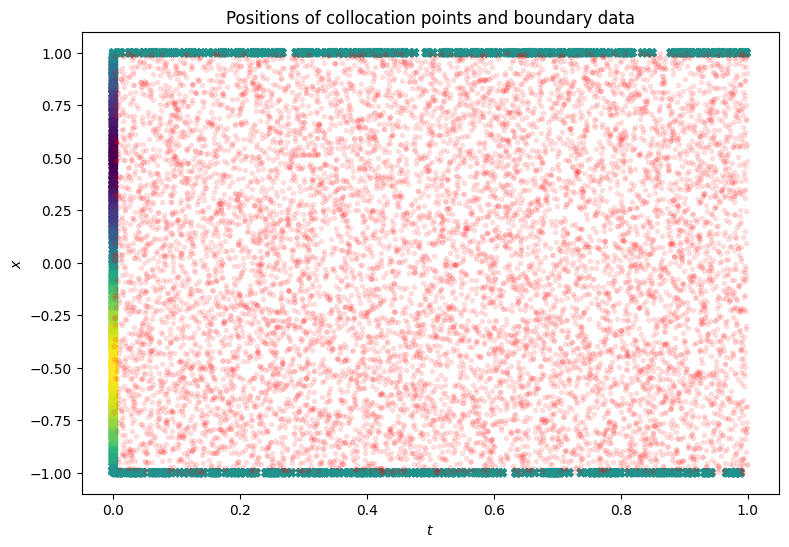

In [9]:
fig = plt.figure(figsize=(9, 6))
plt.scatter(t_0.detach().numpy(), x_0.detach().numpy(), c=u_0.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_b.detach().numpy(), x_b.detach().numpy(), c=u_b.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_r.detach().numpy(), x_r.detach().numpy(), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data')
# plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

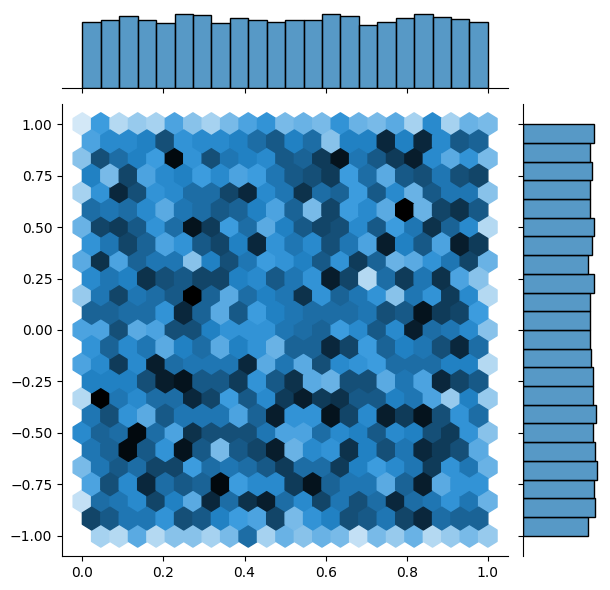

In [10]:
sns.jointplot(
    x=t_r.detach().numpy().flatten(), 
    y=x_r.detach().numpy().flatten(),
    kind="hex",
    
)

plt.show()

# PINN

In [11]:
# Set training parameters
max_epoch = 10000
base_pinn = PINN(
    input_dim=2,
    output_dim=1,
    hidden_layers= 9 * [20], 
    equation=burgers_1d
).to("cpu")
optimizers = {
    "model": optim.Adam(base_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [12]:
train_loss, eval_losses = train_pinn(
    max_epoch, 
    base_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device="cpu",
    random_resample_every_N=1000, lb=lb, ub=ub
)

Epoch: 50/10000, PINN Loss: 0.37877, True Loss: 0.37482
Epoch: 100/10000, PINN Loss: 0.27575, True Loss: 0.27360
Epoch: 150/10000, PINN Loss: 0.15081, True Loss: 0.15086
Epoch: 200/10000, PINN Loss: 0.14653, True Loss: 0.14645
Epoch: 250/10000, PINN Loss: 0.14145, True Loss: 0.14132
Epoch: 300/10000, PINN Loss: 0.13086, True Loss: 0.13058
Epoch: 350/10000, PINN Loss: 0.11699, True Loss: 0.11761
Epoch: 400/10000, PINN Loss: 0.10660, True Loss: 0.10641
Epoch: 450/10000, PINN Loss: 0.09923, True Loss: 0.09922
Epoch: 500/10000, PINN Loss: 0.09569, True Loss: 0.09563
Epoch: 550/10000, PINN Loss: 0.09228, True Loss: 0.09221
Epoch: 600/10000, PINN Loss: 0.08843, True Loss: 0.08835
Epoch: 650/10000, PINN Loss: 0.08350, True Loss: 0.08352
Epoch: 700/10000, PINN Loss: 0.06699, True Loss: 0.06766
Epoch: 750/10000, PINN Loss: 0.05533, True Loss: 0.05471
Epoch: 800/10000, PINN Loss: 0.05301, True Loss: 0.05204
Epoch: 850/10000, PINN Loss: 0.04533, True Loss: 0.04523
Epoch: 900/10000, PINN Loss: 0.0

In [13]:
# Set up meshgrid
base_pinn.to("cpu")
torch.cuda.empty_cache()
N = 501
T, X, U = compute_approximation_2d(base_pinn, lb, ub, N)

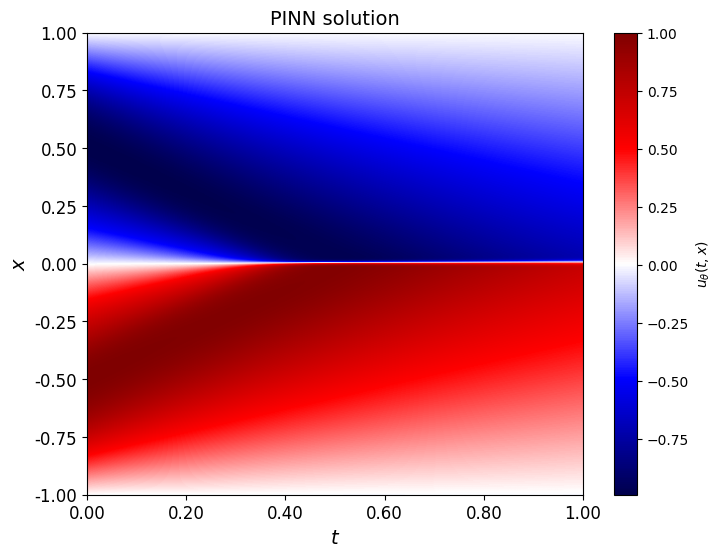

In [14]:
plot_single_heatmap_2d(T, X, U, title="PINN solution")

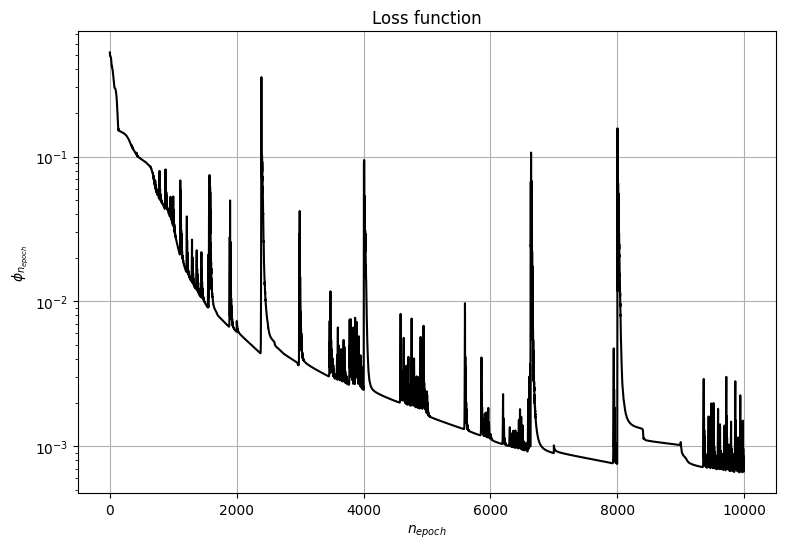

In [15]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(eval_losses)), eval_losses,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
ax.set_title('Loss function')
plt.grid()
# plt.savefig('../pics/1d_burgers/loss/burgers_v5.png', bbox_inches='tight', dpi=300);

In [16]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "pinn.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "loss", "pinn.json") )
save_model(base_pinn, os.path.join("..", "saved_models", "1d_burgers", "pinn.pt"))

# RFF-PINN

In [17]:
# Set training parameters
max_epoch = 10000
rff_pinn = PINN(
    input_dim=2,
    rff_features=20,
    output_dim=1,
    hidden_layers= 9 * [42],
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(rff_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [18]:
rff_pinn.to(device)
train_loss, eval_losses = train_pinn(
    max_epoch, 
    rff_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    random_resample_every_N=1000, lb=lb, ub=ub
)

c:\Users\ritka\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 50/10000, PINN Loss: 0.32384, True Loss: 0.32177
Epoch: 100/10000, PINN Loss: 0.21514, True Loss: 0.21374
Epoch: 150/10000, PINN Loss: 0.14700, True Loss: 0.14652
Epoch: 200/10000, PINN Loss: 0.13129, True Loss: 0.13103
Epoch: 250/10000, PINN Loss: 0.12095, True Loss: 0.12070
Epoch: 300/10000, PINN Loss: 0.10342, True Loss: 0.10321
Epoch: 350/10000, PINN Loss: 0.06465, True Loss: 0.06336
Epoch: 400/10000, PINN Loss: 0.04032, True Loss: 0.04475
Epoch: 450/10000, PINN Loss: 0.03230, True Loss: 0.03220
Epoch: 500/10000, PINN Loss: 0.02256, True Loss: 0.02227
Epoch: 550/10000, PINN Loss: 0.02409, True Loss: 0.02596
Epoch: 600/10000, PINN Loss: 0.01818, True Loss: 0.01966
Epoch: 650/10000, PINN Loss: 0.05819, True Loss: 0.02452
Epoch: 700/10000, PINN Loss: 0.01578, True Loss: 0.01562
Epoch: 750/10000, PINN Loss: 0.01270, True Loss: 0.01266
Epoch: 800/10000, PINN Loss: 0.01133, True Loss: 0.01131
Epoch: 850/10000, PINN Loss: 0.01021, True Loss: 0.01019
Epoch: 900/10000, PINN Loss: 0.0

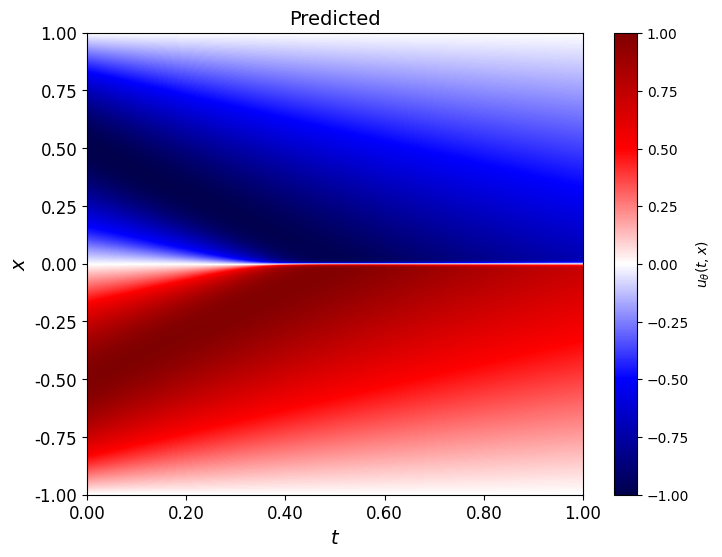

In [19]:
rff_pinn.to("cpu")
T, X, U = compute_approximation_2d(rff_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

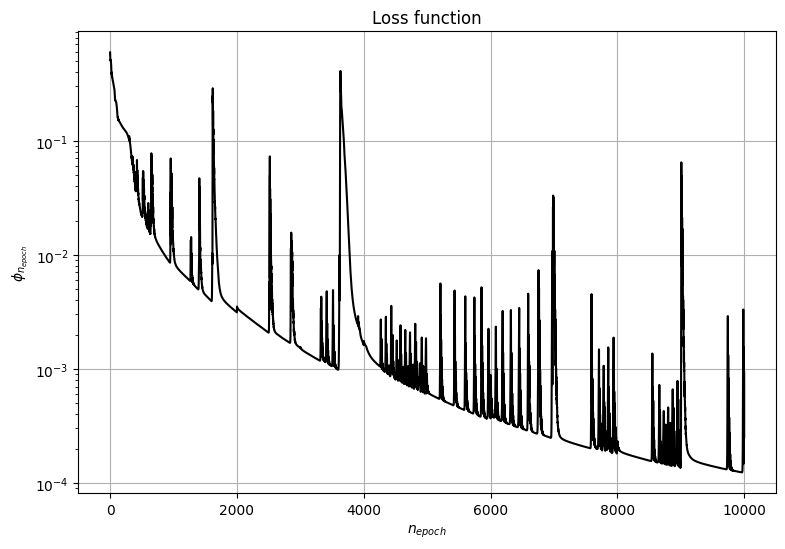

In [20]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(eval_losses)), eval_losses,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
ax.set_title('Loss function')
plt.grid()
# plt.savefig('../pics/1d_burgers/loss/burgers_v5.png', bbox_inches='tight', dpi=300);

In [21]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "rff_pinn.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "loss", "rff_pinn.json"))
save_model(rff_pinn, os.path.join("..", "saved_models", "1d_burgers", "rff_pinn.pt"))

# SA-PINN + RFF

In [22]:
# Set training parameters
max_epoch = 10000
sa_pinn = SA_PINN(
    input_dim=2,
    output_dim=1,
    activation=torch.nn.Tanh(),
    hidden_layers= 9 * [42],
    equation=burgers_1d,
    points_pde=X_r,
    points_ics=X_0,
    points_bcs=X_b
).to(device)
optimizer = torch.optim.Adam(sa_pinn.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.9)
optimizers = {
    "model": optim.Adam(sa_pinn.u_model.parameters(), lr=1e-4),
    "lambdas_pde": optim.Adam([sa_pinn.lambdas_pde], lr=1e-2),
    "lambdas_ics": optim.Adam([sa_pinn.lambdas_ics], lr=1e-2),
    "lambdas_bcs": optim.Adam([sa_pinn.lambdas_bcs], lr=1e-2)
}
schedulers = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9),
    "lambdas_pde": LambdaScheduler(optimizers["lambdas_pde"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9),
    "lambdas_ics": LambdaScheduler(optimizers["lambdas_ics"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9),
    "lambdas_bcs": LambdaScheduler(optimizers["lambdas_bcs"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9)
}

c:\Users\ritka\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [23]:
sa_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    sa_pinn, optimizers, schedulers,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    random_resample_every_N=1000, lb=lb, ub=ub
)

Epoch: 50/10000, PINN Loss: 0.47746, True Loss: 0.47542
Epoch: 100/10000, PINN Loss: 0.42087, True Loss: 0.42074
Epoch: 150/10000, PINN Loss: 0.41329, True Loss: 0.41310
Epoch: 200/10000, PINN Loss: 0.39770, True Loss: 0.39715
Epoch: 250/10000, PINN Loss: 0.33848, True Loss: 0.33670
Epoch: 300/10000, PINN Loss: 0.28213, True Loss: 0.28149
Epoch: 350/10000, PINN Loss: 0.23987, True Loss: 0.23890
Epoch: 400/10000, PINN Loss: 0.19146, True Loss: 0.19024
Epoch: 450/10000, PINN Loss: 0.16175, True Loss: 0.16161


KeyboardInterrupt: 

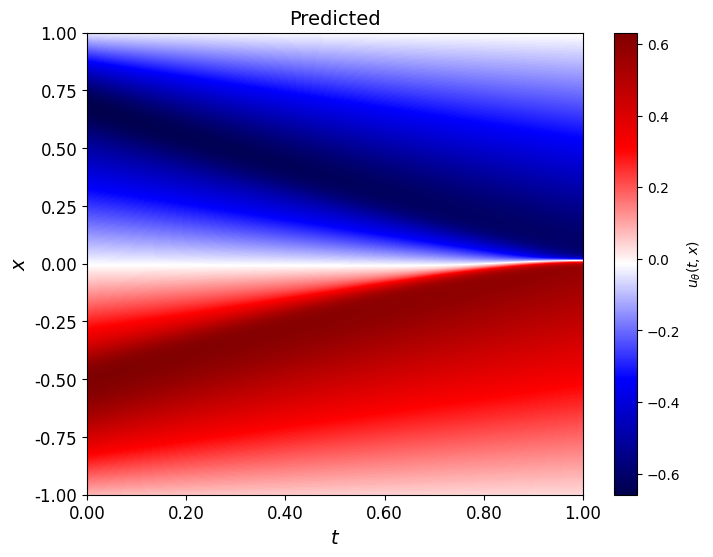

In [ ]:
sa_pinn.to("cpu")
T, X, U = compute_approximation_2d(sa_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

In [ ]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "sa_rff_pinn.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "loss", "sa_rff_pinn.json") )
save_model(rff_pinn, os.path.join("..", "saved_models", "1d_burgers", "sa_rff_pinn.pt"))

# DB-PINN + RFF

In [16]:
# Set training parameters
max_epoch = 10000
db_pinn = DB_PINN(
    input_dim=2,
    rff_features=20,
    output_dim=1,
    hidden_layers= 9 * [42],
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(db_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [17]:
db_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    db_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    show_distinct_losses=True
)

Epoch: 50/10000, PINN Loss: 1.94158, True Loss: 0.39711
physics_loss: 0.32099
boundary_loss: 0.02537
initial_loss: 0.05076
data_loss: 0.00000
Epoch: 100/10000, PINN Loss: 0.61546, True Loss: 0.48223
physics_loss: 0.47822
boundary_loss: 0.00111
initial_loss: 0.00290
data_loss: 0.00000
Epoch: 150/10000, PINN Loss: 0.55531, True Loss: 0.43458
physics_loss: 0.43248
boundary_loss: 0.00063
initial_loss: 0.00147
data_loss: 0.00000
Epoch: 200/10000, PINN Loss: 0.48802, True Loss: 0.43076
physics_loss: 0.42965
boundary_loss: 0.00034
initial_loss: 0.00077
data_loss: 0.00000
Epoch: 250/10000, PINN Loss: 0.49946, True Loss: 0.41820
physics_loss: 0.41543
boundary_loss: 0.00160
initial_loss: 0.00116
data_loss: 0.00000
Epoch: 300/10000, PINN Loss: 0.46119, True Loss: 0.42365
physics_loss: 0.42305
boundary_loss: 0.00021
initial_loss: 0.00039
data_loss: 0.00000
Epoch: 350/10000, PINN Loss: 0.46022, True Loss: 0.42698
physics_loss: 0.42655
boundary_loss: 0.00020
initial_loss: 0.00024
data_loss: 0.00000


In [25]:
eval_loss[-1][1]

{'physics_loss': tensor(0.0022),
 'boundary_loss': tensor(1.7624e-06),
 'initial_loss': tensor(3.1617e-06),
 'data_loss': tensor(0.)}

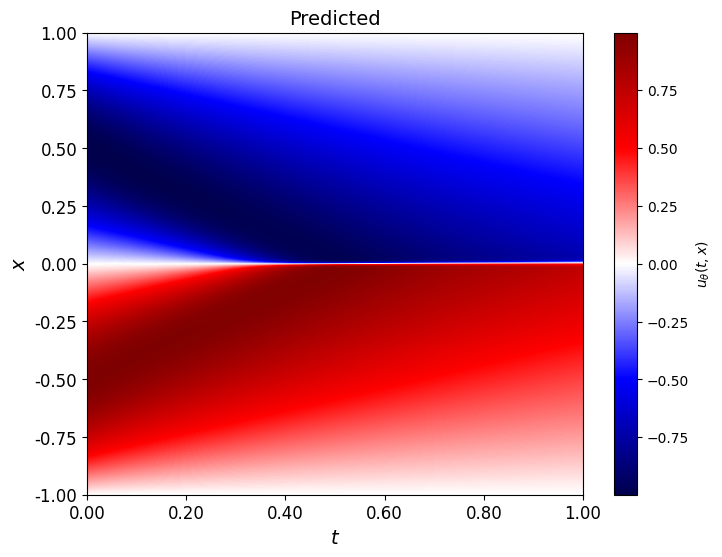

In [19]:
N = 501
db_pinn.to("cpu")
T, X, U = compute_approximation_2d(db_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

In [ ]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "db_rff_pinn.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "loss", "db_rff_pinn.json") )
save_model(db_pinn, os.path.join("..", "saved_models", "1d_burgers", "db_rff_pinn.pt"))

TypeError: Object of type Tensor is not JSON serializable

# PirateNet PINN

In [24]:
# Set training parameters
max_epoch = 10000
piratenet_pinn = PirateNetPINN(
    input_dim=2,
    rff_features=20,
    output_dim=1,
    num_blocks=3,
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(piratenet_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [25]:
piratenet_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    piratenet_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    random_resample_every_N=1000, lb=lb, ub=ub
)

Epoch: 50/10000, PINN Loss: 0.31841, True Loss: 0.31422
Epoch: 100/10000, PINN Loss: 0.15287, True Loss: 0.15203
Epoch: 150/10000, PINN Loss: 0.11378, True Loss: 0.11292
Epoch: 200/10000, PINN Loss: 0.07884, True Loss: 0.07801
Epoch: 250/10000, PINN Loss: 0.04340, True Loss: 0.04521
Epoch: 300/10000, PINN Loss: 0.01944, True Loss: 0.01961
Epoch: 350/10000, PINN Loss: 0.01058, True Loss: 0.01052
Epoch: 400/10000, PINN Loss: 0.00766, True Loss: 0.00750
Epoch: 450/10000, PINN Loss: 0.00491, True Loss: 0.00487
Epoch: 500/10000, PINN Loss: 0.00421, True Loss: 0.00459
Epoch: 550/10000, PINN Loss: 0.00265, True Loss: 0.00264
Epoch: 600/10000, PINN Loss: 0.00234, True Loss: 0.00208
Epoch: 650/10000, PINN Loss: 0.00239, True Loss: 0.00266
Epoch: 700/10000, PINN Loss: 0.00218, True Loss: 0.00209
Epoch: 750/10000, PINN Loss: 0.00128, True Loss: 0.00126
Epoch: 800/10000, PINN Loss: 0.03690, True Loss: 0.04417
Epoch: 850/10000, PINN Loss: 0.01136, True Loss: 0.01110
Epoch: 900/10000, PINN Loss: 0.0

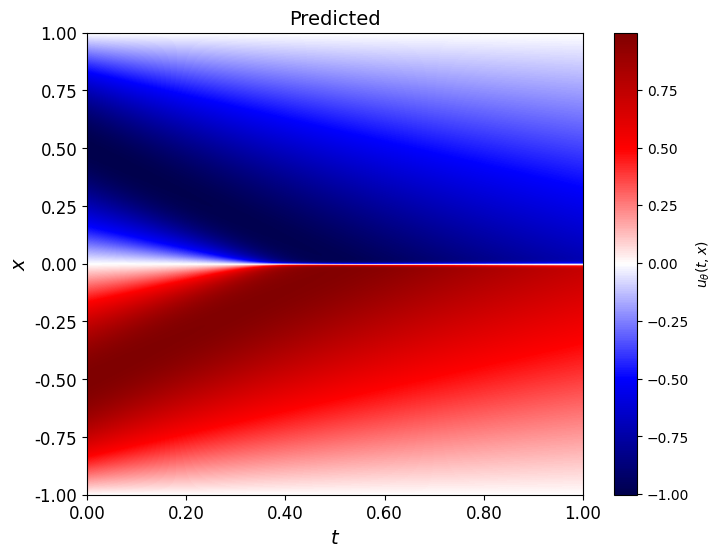

In [26]:
N = 501
piratenet_pinn.to("cpu")
T, X, U = compute_approximation_2d(piratenet_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

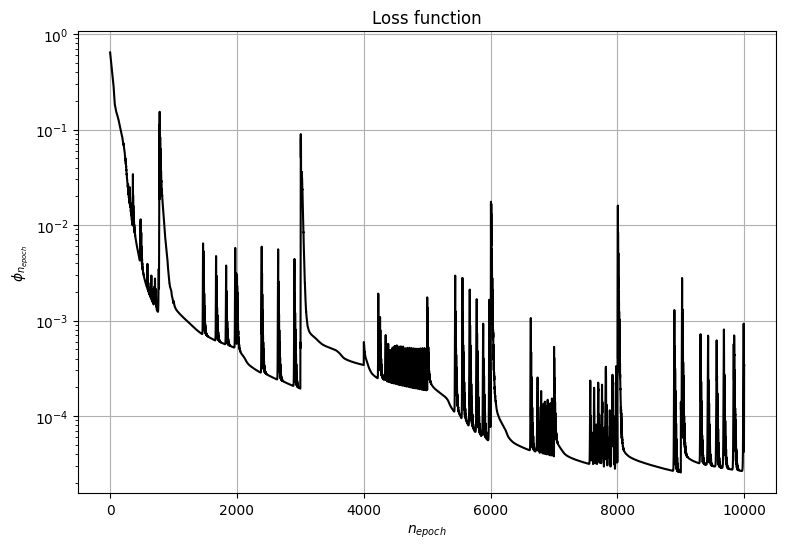

In [27]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(eval_loss)), eval_loss,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
ax.set_title('Loss function')
plt.grid()
# plt.savefig('../pics/1d_burgers/loss/burgers_v5.png', bbox_inches='tight', dpi=300);

In [28]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "piratenet_pinn.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "loss", "piratenet_pinn.json") )
save_model(piratenet_pinn, os.path.join("..", "saved_models", "1d_burgers", "piratenet_pinn.pt"))

# PINN (ResNet) PINN

In [11]:
# Set training parameters
max_epoch = 10000
resnet_pinn = BasePINN(
    input_dim=2,
    hidden_layers=9 * [42],
    model_class=ResNet,
    loss_class=PINN_Loss,
    rff_features=20,
    output_dim=1,
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(resnet_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [12]:
resnet_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    resnet_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device,
    random_resample_every_N=1000, lb=lb, ub=ub
)

c:\Users\ritka\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 50/10000, PINN Loss: 0.16202, True Loss: 0.16028
Epoch: 100/10000, PINN Loss: 0.14028, True Loss: 0.14002
Epoch: 150/10000, PINN Loss: 0.12441, True Loss: 0.12404
Epoch: 200/10000, PINN Loss: 0.10755, True Loss: 0.10729
Epoch: 250/10000, PINN Loss: 0.09902, True Loss: 0.09891
Epoch: 300/10000, PINN Loss: 0.09343, True Loss: 0.09331
Epoch: 350/10000, PINN Loss: 0.08667, True Loss: 0.08651
Epoch: 400/10000, PINN Loss: 0.07951, True Loss: 0.07917
Epoch: 450/10000, PINN Loss: 0.09177, True Loss: 0.12123
Epoch: 500/10000, PINN Loss: 0.05900, True Loss: 0.05882
Epoch: 550/10000, PINN Loss: 0.07892, True Loss: 0.06941
Epoch: 600/10000, PINN Loss: 0.04011, True Loss: 0.03966
Epoch: 650/10000, PINN Loss: 0.04974, True Loss: 0.11403
Epoch: 700/10000, PINN Loss: 0.02463, True Loss: 0.02456
Epoch: 750/10000, PINN Loss: 0.01693, True Loss: 0.01682
Epoch: 800/10000, PINN Loss: 0.02975, True Loss: 0.02541
Epoch: 850/10000, PINN Loss: 0.01382, True Loss: 0.01378
Epoch: 900/10000, PINN Loss: 0.0

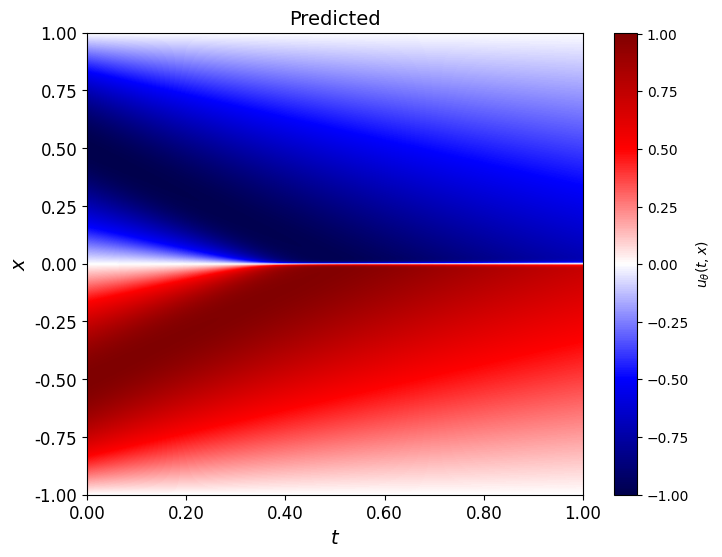

In [13]:
N = 501
resnet_pinn.to("cpu")
T, X, U = compute_approximation_2d(resnet_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

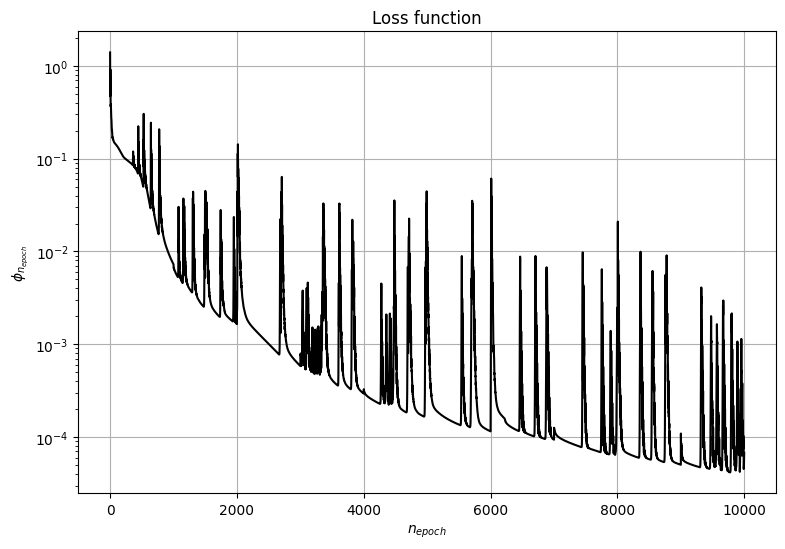

In [14]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(eval_loss)), eval_loss,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
ax.set_title('Loss function')
plt.grid()
# plt.savefig('../pics/1d_burgers/loss/burgers_v5.png', bbox_inches='tight', dpi=300);

In [15]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "resnet_pinn.json"))
save_eval_losses(eval_loss, os.path.join("..", "data", "loss", "resnet_pinn.json") )
save_model(resnet_pinn, os.path.join("..", "saved_models", "1d_burgers", "resnet_pinn.pt"))

# Analytic solution

In [ ]:
correct = burgers_1d.analytical_solution(T, X)
plot_single_heatmap_2d(T, X, correct, title="Analytical") 

KeyboardInterrupt: 

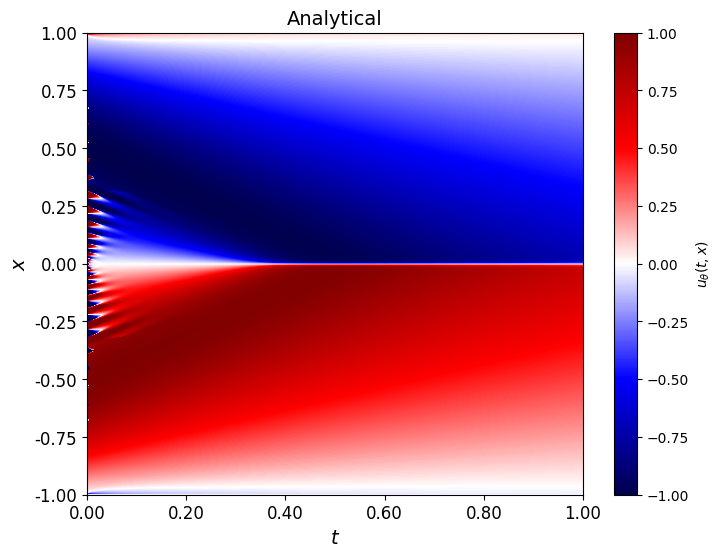

In [ ]:
plot_single_heatmap_2d(
    T, X, correct.clip(min=-1, max=1, out=correct), 
    title="Analytical"
) 

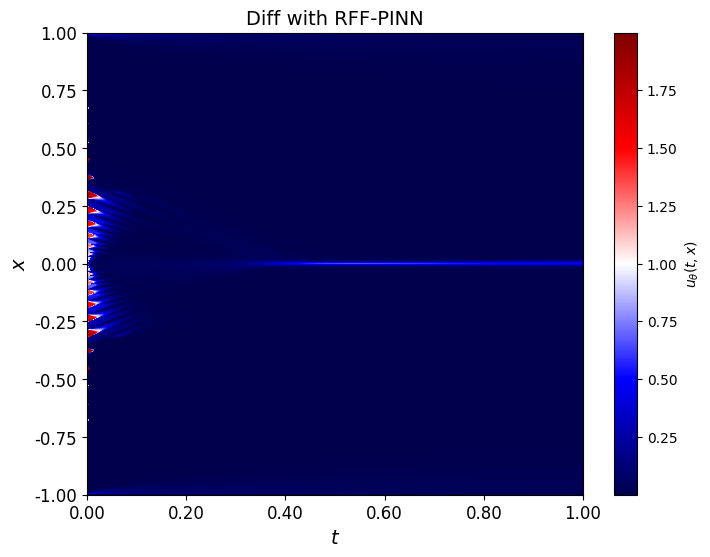

In [ ]:
with open(os.path.join("..", "data", "results", "rff_pinn.json")) as f:
    data = json.load(f)
plot_single_heatmap_2d(
    T, X, np.abs(data["u_map"] - correct.clip(min=-1, max=1, out=correct)), 
    title="Diff with RFF-PINN"
) 

# Comparasion

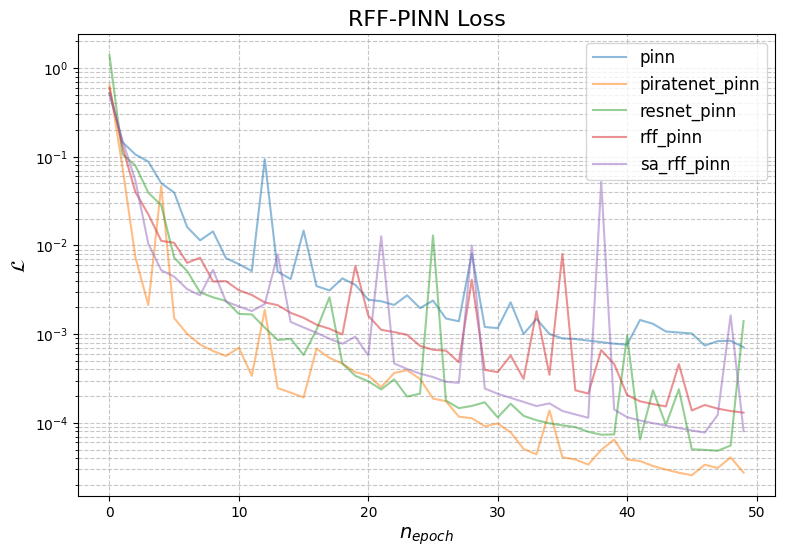

In [22]:
# отрисовка сохраненных графиков
mask_path = os.listdir(os.path.join("..", "data", "loss"))
losses = dict(zip(mask_path, [None] * len(mask_path)))
for mask in mask_path:
    with open(os.path.join("..", "data", "loss",  mask)) as f:
        data = json.load(f)
    losses[mask.split('.')[0]] = data[::200]
plot_loss(
    losses, title="RFF-PINN Loss", alpha=0.5,
    # save_path=os.path.join("..", "pics", "1d_burgers", "loss", "rff_pinn_v001divpi.png")
)